In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from pathlib import Path

## Preprocessing

In [2]:
dir_path = "/workspaces/gorillatracker/datasets/splits/-workspaces-gorillatracker-data-ground_truth-cxl_all-face_images-kfold-actual_openset-seed-42-trainval-80-test-20-k-5"

In [3]:
dirs = os.listdir(dir_path)
print(dirs)

['fold-2', 'fold-3', 'fold-1', 'fold-0', 'fold-4', 'test']


In [4]:
#create a dataframe for each directory
df: list[pd.DataFrame] = []

for i, d in enumerate(dirs):
    data = []
    solitary_data = 0
    # Extract data from filenames
    for filename in os.listdir(os.path.join(dir_path, d)):
        parts = filename.split('_')
        if len(parts) >= 4:
            id_, camid, date, id2 = parts[:4]
            solitary = False
            if(len(id_) != 4):  # if != 4, then the gorilla is a solitary one without a group
                # print(f"Solitary in {filename}")
                solitary_data += 1
                solitary = True
            Groupid = id_[:2] if not solitary else "SOLITARY"
            id_ = id_[2:] if not solitary else ''.join(filter(str.isdigit, id_))
            id2 = ''.join(filter(str.isdigit, id2)) # remove non-numeric characters
            date = dt.datetime.strptime(date, '%Y%m%d').date()
            data.append((Groupid, id_, camid, date, id2, f"{dir_path}/{d}/{filename}"))
        else:
            print(f"Invalid filename {filename}")
            
    # Create a DataFrame
    df.append(pd.DataFrame(data, columns=['GROUP', 'ID', 'CAM', 'DATE', 'ID2', 'FILENAME']))
    print(f"Directory {d} had {solitary_data} images of solitary gorillas with no group")

Directory fold-2 had 2 images of solitary gorillas with no group
Directory fold-3 had 50 images of solitary gorillas with no group
Directory fold-1 had 0 images of solitary gorillas with no group
Directory fold-0 had 0 images of solitary gorillas with no group
Directory fold-4 had 5 images of solitary gorillas with no group
Directory test had 1 images of solitary gorillas with no group


In [5]:
print(df[2]["FILENAME"][0])

/workspaces/gorillatracker/datasets/splits/-workspaces-gorillatracker-data-ground_truth-cxl_all-face_images-kfold-actual_openset-seed-42-trainval-80-test-20-k-5/fold-1/JZ40_R507_20210107_043bSideboard.png


## Plot the Number of Videos per Individual

fold-2:
	 Images: 224
	 Individuals: 20
	 Groups: 14
	 Cameras: 13
	 Days: 35
	 DateRange: 2019-10-12 - 2023-09-17
	 Video_clips: 86
	 Videos: 36
fold-3:
	 Images: 224
	 Individuals: 20
	 Groups: 16
	 Cameras: 14
	 Days: 31
	 DateRange: 2019-07-27 - 2023-07-18
	 Video_clips: 88
	 Videos: 33
fold-1:
	 Images: 225
	 Individuals: 20
	 Groups: 11
	 Cameras: 11
	 Days: 35
	 DateRange: 2019-07-27 - 2023-09-13
	 Video_clips: 87
	 Videos: 36
fold-0:
	 Images: 225
	 Individuals: 20
	 Groups: 10
	 Cameras: 11
	 Days: 25
	 DateRange: 2019-03-14 - 2023-07-18
	 Video_clips: 87
	 Videos: 27
fold-4:
	 Images: 224
	 Individuals: 20
	 Groups: 15
	 Cameras: 16
	 Days: 33
	 DateRange: 2018-12-02 - 2023-05-20
	 Video_clips: 91
	 Videos: 34
test:
	 Images: 206
	 Individuals: 30
	 Groups: 16
	 Cameras: 18
	 Days: 43
	 DateRange: 2018-10-03 - 2023-09-13
	 Video_clips: 85
	 Videos: 43
Combined:
	 Images: 1328
	 Individuals: 130
	 Groups: 26
	 Cameras: 26
	 Days: 115
	 DateRange: 2018-10-03 - 2023-09-17
	 Vide

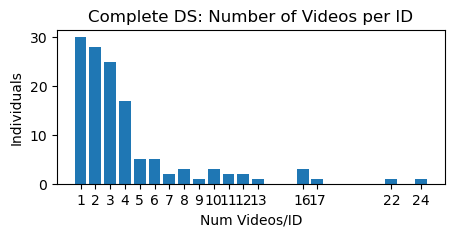

In [6]:
for i, d in enumerate(dirs):
    print(f"{d}:")
    print(f"\t Images: {df[i].shape[0]}")
    print(f"\t Individuals: {df[i].groupby(['GROUP', 'ID']).ngroups}")
    print(f"\t Groups: {df[i]['GROUP'].nunique()}")
    print(f"\t Cameras: {df[i]['CAM'].nunique()}")
    print(f"\t Days: {df[i]['DATE'].nunique()}")
    print(f"\t DateRange: {df[i]['DATE'].min()} - {df[i]['DATE'].max()}")
    print(f"\t Video_clips: {df[i].groupby(['CAM', 'DATE', 'ID2']).ngroups}")
    print(f"\t Videos: {df[i].groupby(['CAM', 'DATE']).ngroups}")
    
df_combined = pd.concat(df)
print(f"Combined:")
print(f"\t Images: {len(df_combined)}")
print(f"\t Individuals: {df_combined.groupby(['GROUP', 'ID']).ngroups}")
print(f"\t Groups: {df_combined['GROUP'].nunique()}")
print(f"\t Cameras: {df_combined['CAM'].nunique()}")
print(f"\t Days: {df_combined['DATE'].nunique()}")
print(f"\t DateRange: {df_combined['DATE'].min()} - {df_combined['DATE'].max()}")
print(f"\t Video_clips: {df_combined.groupby(['CAM', 'DATE', 'ID2']).ngroups}")
print(f"\t Videos: {df_combined.groupby(['CAM', 'DATE']).ngroups}")

unique_videos = df_combined.drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
videos_per_id = unique_videos.groupby(['GROUP', 'ID']).size()
videos_count_distribution = videos_per_id.value_counts().sort_index()
plt.figure(figsize=(5, 2))
plt.bar(videos_count_distribution.index, videos_count_distribution.values)
plt.xlabel('Num Videos/ID')
plt.ylabel('Individuals')
plt.title(f'Complete DS: Number of Videos per ID')
plt.xticks(videos_count_distribution.index)
plt.show()

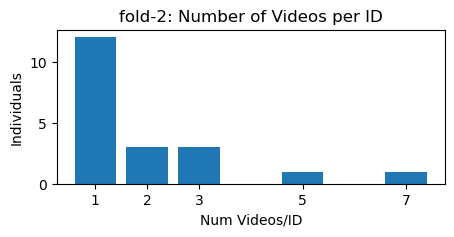

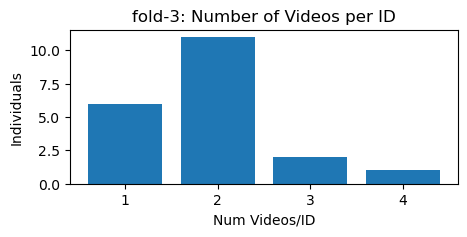

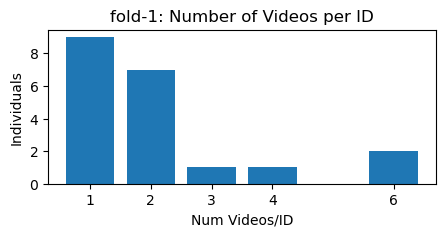

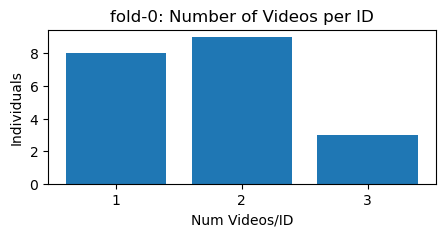

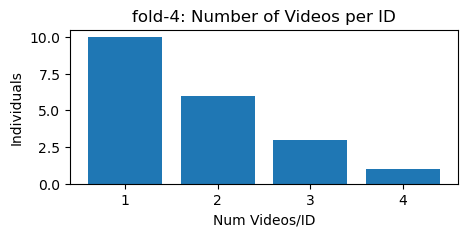

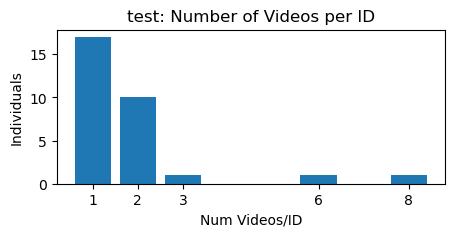

In [7]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE'])
    videos_per_id = unique_videos.groupby(['GROUP', 'ID']).size()
    videos_count_distribution = videos_per_id.value_counts().sort_index()
    plt.figure(figsize=(5, 2))
    plt.bar(videos_count_distribution.index, videos_count_distribution.values)
    plt.xlabel('Num Videos/ID')
    plt.ylabel('Individuals')
    plt.title(f'{d}: Number of Videos per ID')
    plt.xticks(videos_count_distribution.index)
    plt.show()


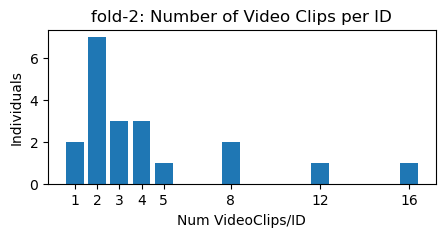

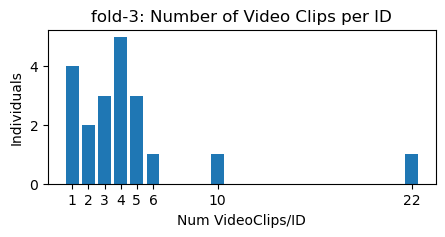

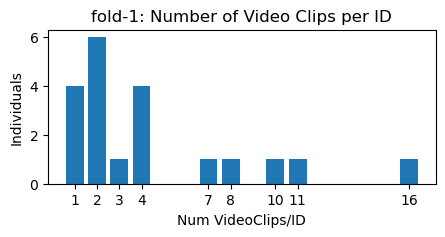

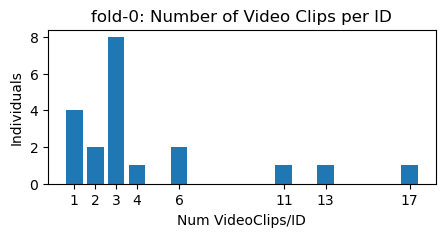

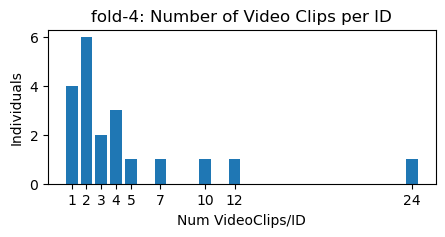

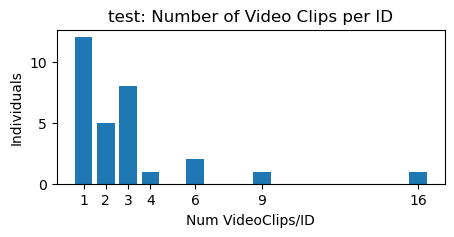

In [8]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
    videos_per_id = unique_videos.groupby(['GROUP', 'ID']).size()
    videos_count_distribution = videos_per_id.value_counts().sort_index()
    plt.figure(figsize=(5, 2))
    plt.bar(videos_count_distribution.index, videos_count_distribution.values)
    plt.xlabel('Num VideoClips/ID')
    plt.ylabel('Individuals')
    plt.title(f'{d}: Number of Video Clips per ID')
    plt.xticks(videos_count_distribution.index)
    plt.show()

## Number of Images of Individuals with at least 2 Videos

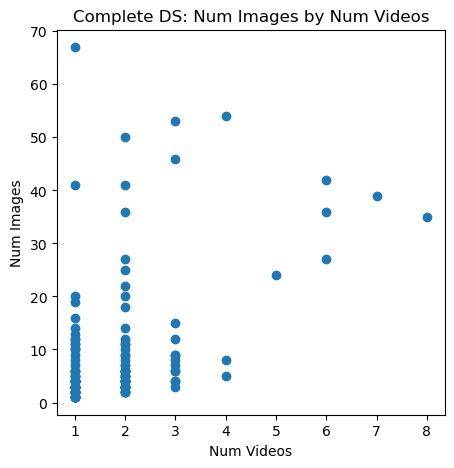

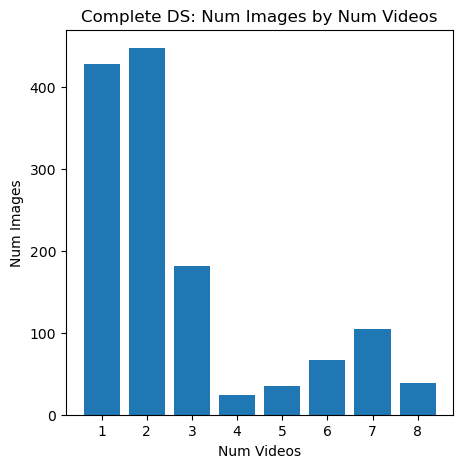

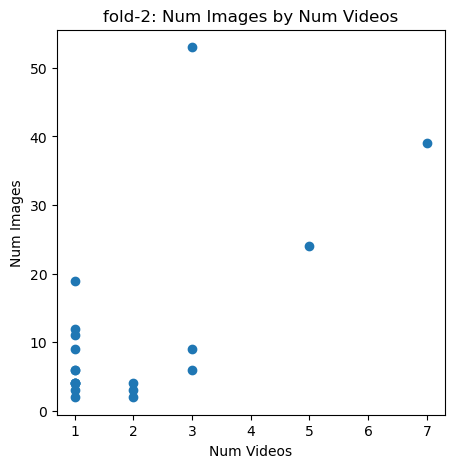

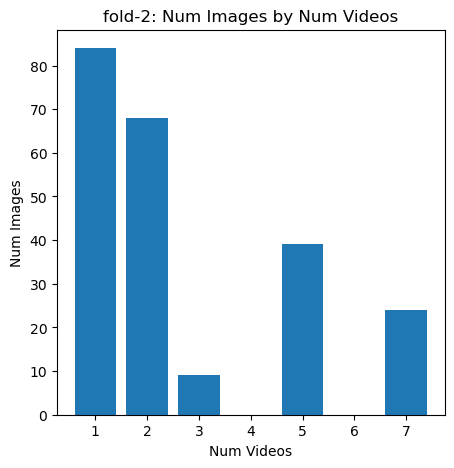

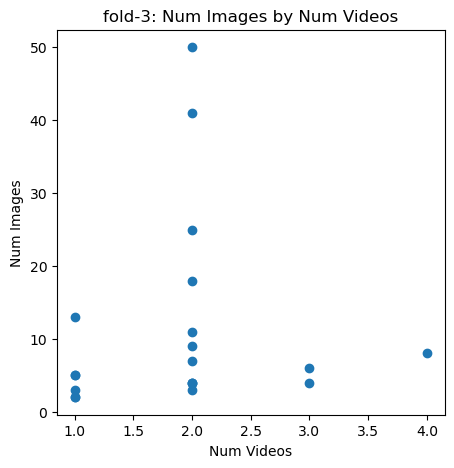

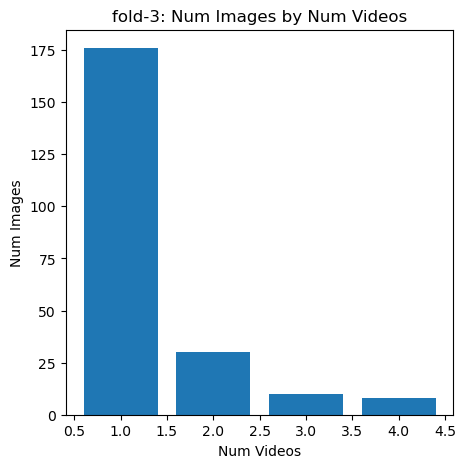

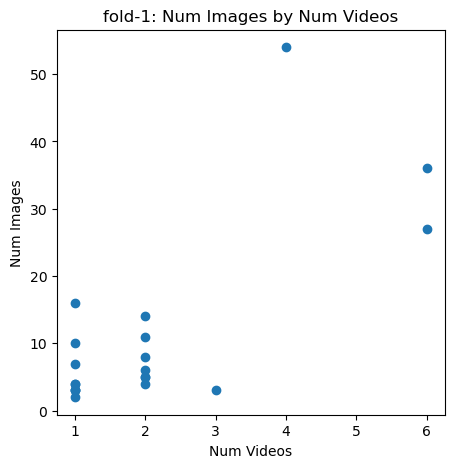

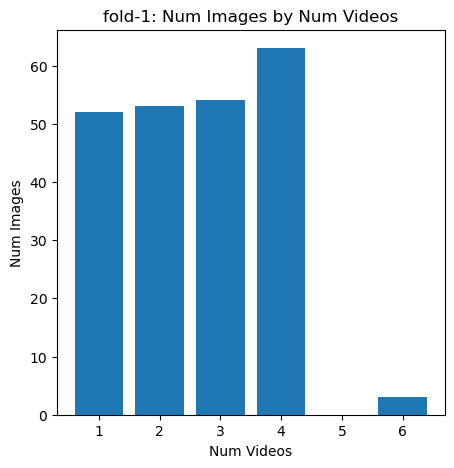

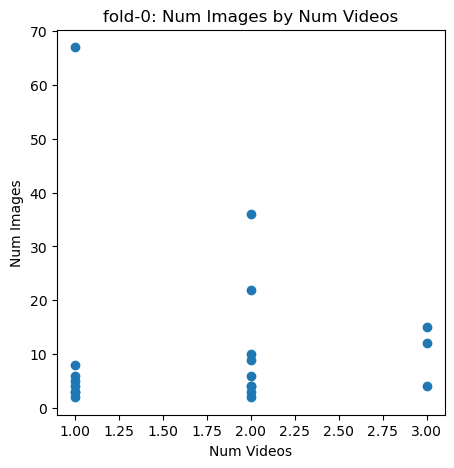

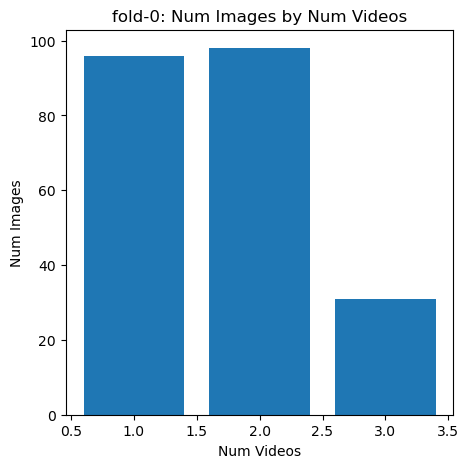

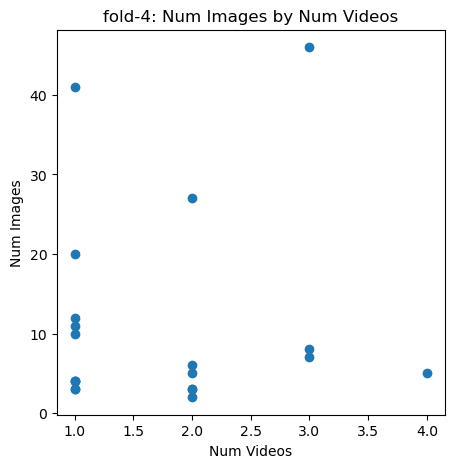

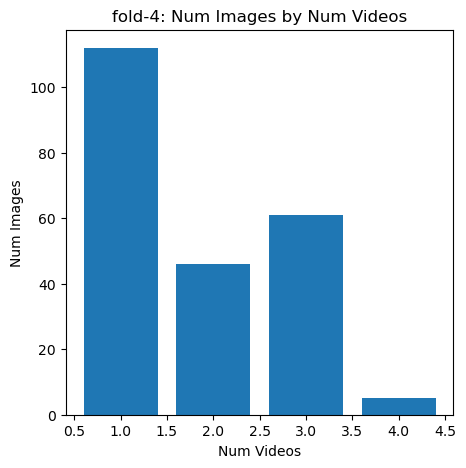

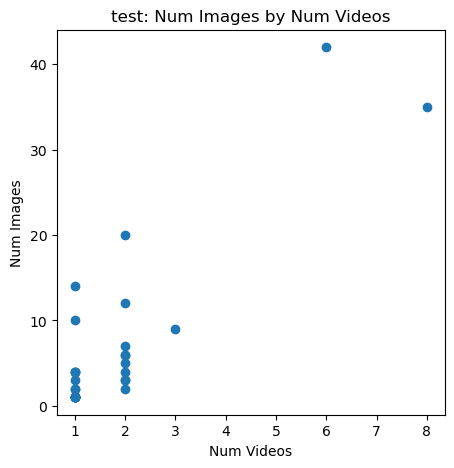

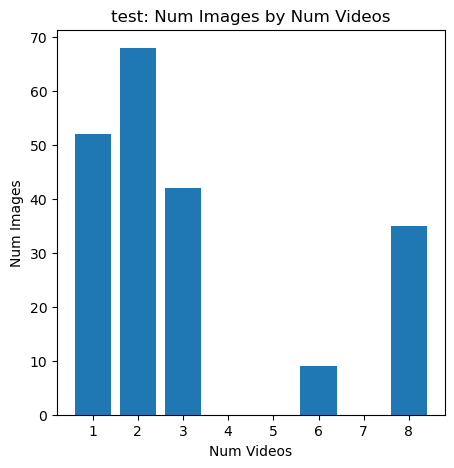

In [9]:
df_combined = pd.concat(df)
unique_videos = df_combined.drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE'])

videos_per_id = unique_videos[['GROUP', 'ID']].copy()
videos_per_id = videos_per_id.groupby(['GROUP', 'ID']).size().reset_index()
images_per_video = df_combined[["GROUP", "ID"]].copy()
images_per_video = images_per_video.groupby(['GROUP', 'ID']).size()
images_per_video.name = "IMAGES"

video_image_distribution = videos_per_id.join(images_per_video, on=["GROUP", "ID"], how="inner")
video_image_distribution["VIDEOS"] = video_image_distribution[0]
video_image_distribution = video_image_distribution.drop(columns=[0])

# plot num_images by number of videos
plt.figure(figsize=(5, 5))
plt.scatter(video_image_distribution["VIDEOS"], video_image_distribution["IMAGES"])
plt.xlabel('Num Videos')
plt.ylabel('Num Images')
plt.title(f'Complete DS: Num Images by Num Videos')
plt.show()

# number of images per video count
plt.figure(figsize=(5, 5))
plt.bar(video_image_distribution["VIDEOS"].value_counts().index, video_image_distribution.groupby(video_image_distribution["VIDEOS"])["IMAGES"].sum().sort_index().values)
plt.xlabel('Num Videos')
plt.ylabel('Num Images')
plt.title(f'Complete DS: Num Images by Num Videos')
plt.show()



for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE'])
    videos_per_id = unique_videos[['GROUP', 'ID']].copy()
    videos_per_id = videos_per_id.groupby(['GROUP', 'ID']).size().reset_index()
    images_per_video = df[i][["GROUP", "ID"]].copy()
    images_per_video = images_per_video.groupby(['GROUP', 'ID']).size()
    images_per_video.name = "IMAGES"
    video_image_distribution = videos_per_id.join(images_per_video, on=["GROUP", "ID"], how="inner")
    video_image_distribution["VIDEOS"] = video_image_distribution[0]
    video_image_distribution = video_image_distribution.drop(columns=[0])
    # plot num_images by number of videos
    plt.figure(figsize=(5, 5))
    plt.scatter(video_image_distribution["VIDEOS"], video_image_distribution["IMAGES"])
    plt.xlabel('Num Videos')
    plt.ylabel('Num Images')
    plt.title(f'{d}: Num Images by Num Videos')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.bar(video_image_distribution["VIDEOS"].value_counts().index, video_image_distribution.groupby(video_image_distribution["VIDEOS"])["IMAGES"].sum().sort_index().values)
    plt.xlabel('Num Videos')
    plt.ylabel('Num Images')
    plt.title(f'{d}: Num Images by Num Videos')
    plt.show()



## Number of Images per Video and per Individual # TODO

In [10]:
from collections import defaultdict

combined_ids = df_combined["GROUP"] + df_combined["ID"]
all_individuals = set(combined_ids.unique())
individual_seen_in = defaultdict(set)
print(dirs)
for i, d in enumerate(dirs):
    print(f"Processing {d}")
    individuals = set((df[i]["GROUP"] + df[i]["ID"]).unique())
    for ind in individuals:
        individual_seen_in[ind].add(d)
        
for ind, aDir in individual_seen_in.items():
    if len(aDir) > 1:
        print(f"{ind} seen in {aDir}")
print(individual_seen_in)

['fold-2', 'fold-3', 'fold-1', 'fold-0', 'fold-4', 'test']
Processing fold-2
Processing fold-3
Processing fold-1
Processing fold-0
Processing fold-4
Processing test
defaultdict(<class 'set'>, {'ES03': {'fold-2'}, 'NN44': {'fold-2'}, 'TU41': {'fold-2'}, 'ME60': {'fold-2'}, 'YE40': {'fold-2'}, 'ME00': {'fold-2'}, 'TU20': {'fold-2'}, 'HU23': {'fold-2'}, 'GA03': {'fold-2'}, 'RC21': {'fold-2'}, 'NN02': {'fold-2'}, 'VI02': {'fold-2'}, 'PL47': {'fold-2'}, 'OE00': {'fold-2'}, 'JZ01': {'fold-2'}, 'TU05': {'fold-2'}, 'HU00': {'fold-2'}, 'AP61': {'fold-2'}, 'VI41': {'fold-2'}, 'SOLITARY92': {'fold-2'}, 'AY00': {'fold-3'}, 'US00': {'fold-3'}, 'YE00': {'fold-3'}, 'GA01': {'fold-3'}, 'SOLITARY0': {'fold-3'}, 'OE40': {'fold-3'}, 'TU60': {'fold-3'}, 'PL03': {'fold-3'}, 'US04': {'fold-3'}, 'NN01': {'fold-3'}, 'ME01': {'fold-3'}, 'AP01': {'fold-3'}, 'YE01': {'fold-3'}, 'RC40': {'fold-3'}, 'ES02': {'fold-3'}, 'HU21': {'fold-3'}, 'ES01': {'fold-3'}, 'RC01': {'fold-3'}, 'DU60': {'fold-3'}, 'GN01': {'fold-3

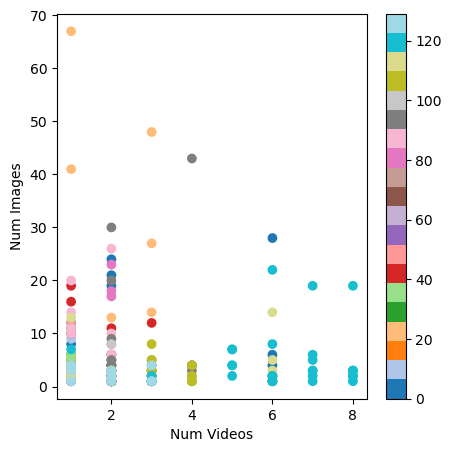

['fold-2', 'fold-3', 'fold-1', 'fold-0', 'fold-4', 'test']
fold-2:
    index   CAM        DATE  IMAGES  VIDEOS COMPLETE_ID
0       0  R066  2022-11-18       9       1        AP61
1       1  R066  2020-10-19       6       1        ES03
2       2  R224  2020-06-06       2       3        GA03
3       3  R224  2020-06-07       3       3        GA03
4       4  R224  2020-06-08      48       3        GA03
5       5  R198  2020-01-16       6       1        HU00
6       6  R198  2020-02-11      12       1        HU23
7       7  R508  2021-05-04      19       1        JZ01
8       8  R465  2021-09-24       1       2        ME00
9       9  R465  2021-11-04       2       2        ME00
10     10  R465  2021-09-18       4       1        ME60
11     11  R018  2021-11-18       4       3        NN02
12     12  R019  2022-03-27       3       3        NN02
13     13  R019  2022-03-28       2       3        NN02
14     14  R019  2021-11-25       4       1        NN44
15     15  R065  2021-10-20       3  

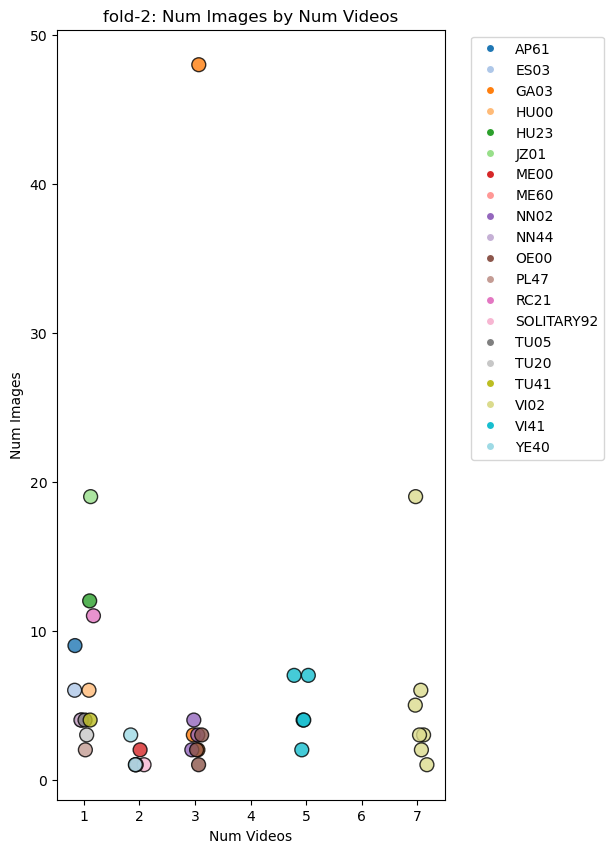

fold-3:
    index   CAM        DATE  IMAGES  VIDEOS COMPLETE_ID
0       0  R066  2022-11-18      19       2        AP01
1       1  R172  2022-09-13       6       2        AP01
2       2  R040  2019-07-27       3       2        AY00
3       3  R040  2020-09-23       1       2        AY00
4       4  R030  2021-11-23       1       2        DU60
5       5  R030  2021-12-02       3       2        DU60
6       6  R066  2020-10-19       5       1        ES01
7       7  R066  2020-06-12       1       2        ES02
8       8  R066  2020-10-19       8       2        ES02
9       9  R018  2022-01-20       1       2        GA01
10     10  R185  2022-01-16       6       2        GA01
11     11  R510  2023-05-20      13       2        GN01
12     12  R510  2023-07-18       5       2        GN01
13     13  R198  2020-01-17       5       1        HU21
14     14  R465  2021-09-20       2       2        ME01
15     15  R465  2021-09-24       1       2        ME01
16     16  R018  2021-11-22       3     

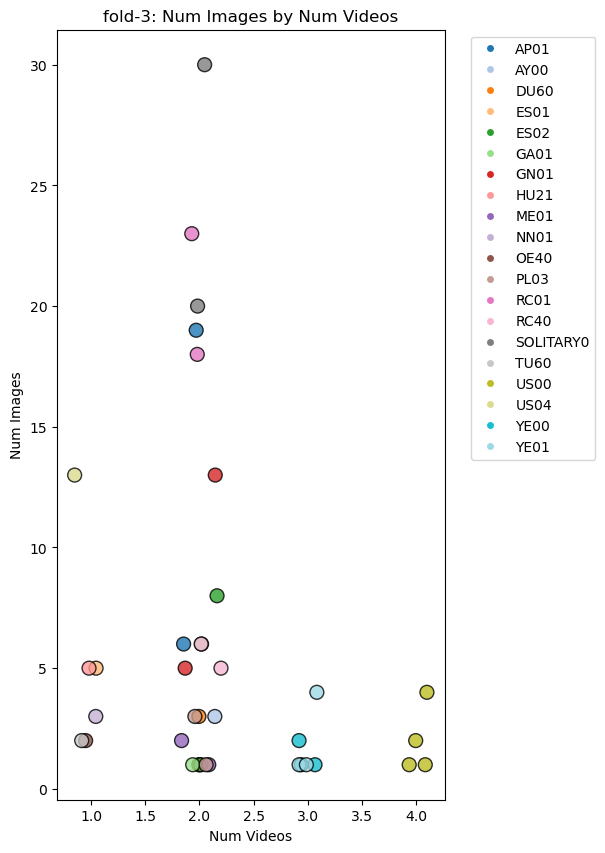

fold-1:
    index   CAM        DATE  IMAGES  VIDEOS COMPLETE_ID
0       0  R040  2019-07-27       1       2        AY04
1       1  R040  2020-10-10       3       2        AY04
2       2  R030  2021-11-23       4       2        DU01
3       3  R030  2022-03-25       1       2        DU01
4       4  R198  2020-02-11      10       1        HU25
5       5  R507  2021-01-07      16       1        JZ40
6       6  R019  2022-01-08       2       1        NN00
7       7  R019  2022-02-04       4       1        NN42
8       8  R019  2022-01-08       3       1        NN61
9       9  R066  2021-08-27       1       2        OE02
10     10  R066  2021-10-12       5       2        OE02
11     11  R066  2021-11-28       3       1        OE41
12     12  R465  2021-10-17       1       3        PL00
13     13  R465  2022-02-03       1       3        PL00
14     14  R465  2022-02-27       1       3        PL00
15     15  R465  2021-12-04       1       2        PL04
16     16  R465  2021-12-30       4     

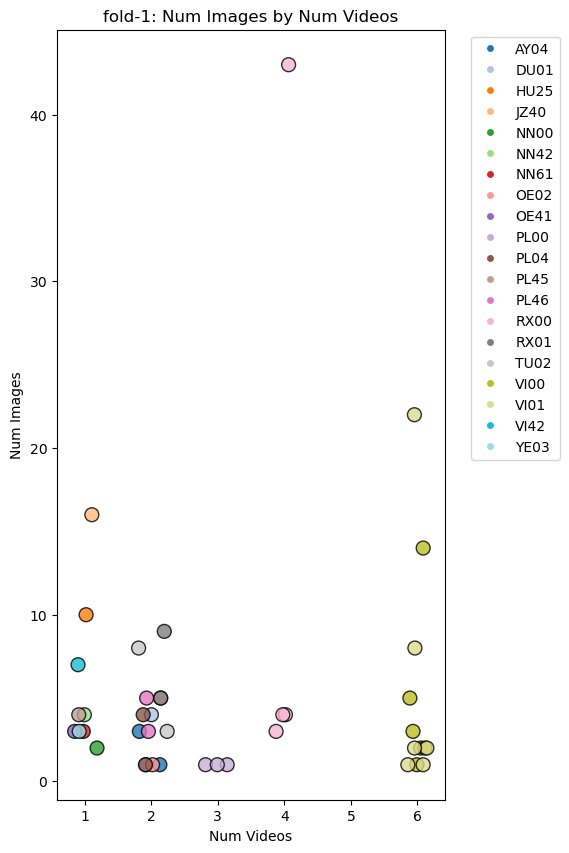

fold-0:
    index   CAM        DATE  IMAGES  VIDEOS COMPLETE_ID
0       0  R066  2022-11-18      21       2        AP02
1       1  R172  2022-09-13       1       2        AP02
2       2  R172  2022-09-13       8       1        AP40
3       3  R066  2022-11-18       2       1        AP60
4       4  R185  2022-01-17       1       2        GA00
5       5  R185  2022-02-27       3       2        GA00
6       6  R185  2022-01-17       4       2        GA40
7       7  R224  2020-06-08       6       2        GA40
8       8  R510  2023-07-18      67       1        GN00
9       9  R198  2020-02-11       6       1        HU24
10     10  R198  2020-01-16       3       1        HU40
11     11  R033  2022-04-07       5       1        JP01
12     12  R507  2021-01-07      12       3        JZ00
13     13  R507  2021-03-04       2       3        JZ00
14     14  R508  2021-05-04       1       3        JZ00
15     15  R465  2022-02-03       2       3        PL40
16     16  R465  2022-02-04       1     

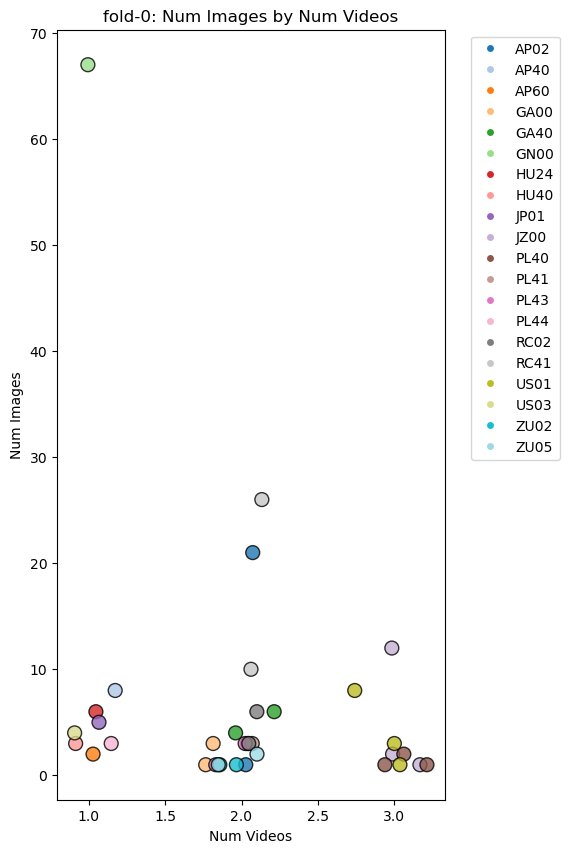

fold-4:
    index    CAM        DATE  IMAGES  VIDEOS COMPLETE_ID
0       0   R066  2022-11-18      24       2        AP03
1       1   R198  2022-09-29       3       2        AP03
2       2   R018  2022-01-20       5       3        GA02
3       3   R224  2020-06-06      14       3        GA02
4       4   R224  2020-06-18      27       3        GA02
5       5   R510  2023-05-20      41       1        GN02
6       6   R065  2018-12-02       1       2        GR01
7       7   R456  2019-03-16       1       2        GR01
8       8   R198  2020-01-17       4       1        HU20
9       9   R198  2020-02-11      11       1        HU22
10     10   R033  2022-03-11       2       2        JP00
11     11   R033  2022-04-07       1       2        JP00
12     12   R033  2022-04-07       4       1        JP60
13     13   R507  2021-01-07      10       1        JZ20
14     14   R051  2022-04-08      12       1        MU00
15     15   R018  2021-09-18       2       2        NN03
16     16   R019  2022-

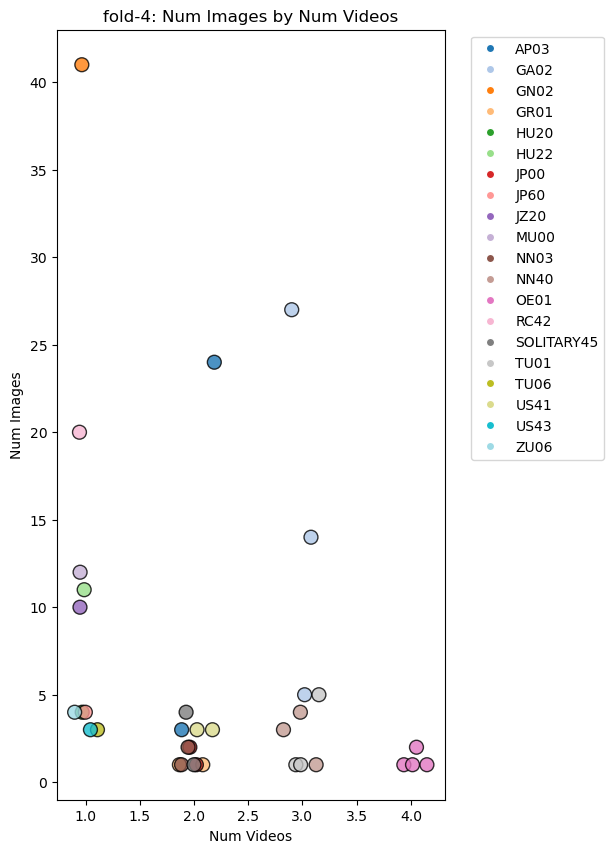

test:
    index   CAM        DATE  IMAGES  VIDEOS   COMPLETE_ID
0       0  R065  2021-10-24       1       1          0E00
1       1  R066  2022-11-18      28       6          AP00
2       2  R172  2022-08-26       6       6          AP00
3       3  R172  2022-08-31       1       6          AP00
4       4  R172  2022-09-01       2       6          AP00
5       5  R198  2022-08-24       4       6          AP00
6       6  R198  2022-10-14       1       6          AP00
7       7  R030  2021-11-23       2       2          DU00
8       8  R030  2021-12-02       1       2          DU00
9       9  R030  2021-12-02       3       2          DU40
10     10  R030  2022-03-25       1       2          DU40
11     11  R066  2020-10-19       3       2          ES00
12     12  R066  2020-11-23       3       2          ES00
13     13  R065  2018-12-02       1       2          GR00
14     14  R456  2019-03-16       1       2          GR00
15     15  R146  2018-10-03       1       1          JB00
16     1

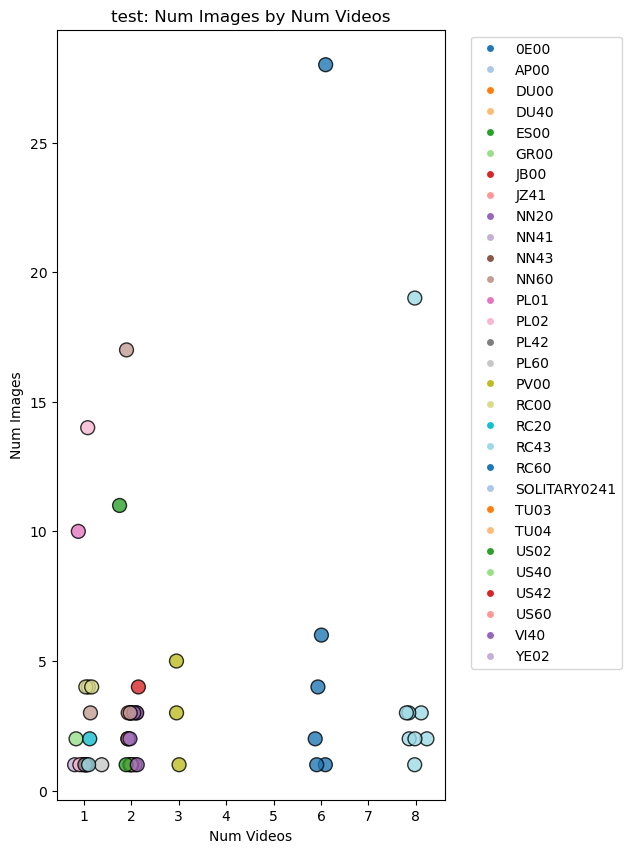

In [11]:
import numpy as np

df_combined = pd.concat(df)
unique_videos = df_combined.drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE'])
videos_per_id = unique_videos[['GROUP', 'ID', 'CAM', 'DATE']].copy().groupby(['GROUP', 'ID']).size().reset_index()

images_per_video = df_combined[["GROUP", "ID", 'CAM', 'DATE']].copy()
images_per_video = images_per_video.groupby(['GROUP', 'ID', 'CAM', 'DATE']).size()
images_per_video.name = "IMAGES"

images_per_video = images_per_video.reset_index().join(videos_per_id.set_index(['GROUP', 'ID']), on=['GROUP', 'ID'], how='inner')
images_per_video["VIDEOS"] = images_per_video[0]
images_per_video = images_per_video.drop(columns=[0])
images_per_video = images_per_video.reset_index()
images_per_video["COMPLETE_ID"] = images_per_video["GROUP"] + images_per_video["ID"]
images_per_video = images_per_video.drop(columns=["GROUP", "ID"])

plt.figure(figsize=(5, 5))
plt.scatter(images_per_video["VIDEOS"], images_per_video["IMAGES"], c=images_per_video["COMPLETE_ID"].astype('category').cat.codes, cmap='tab20')
plt.colorbar()
plt.xlabel('Num Videos')
plt.ylabel('Num Images')
plt.show()

print(dirs)
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE'])
    videos_per_id = unique_videos[['GROUP', 'ID', 'CAM', 'DATE']].copy().groupby(['GROUP', 'ID']).size().reset_index()
    images_per_video = df[i][["GROUP", "ID", 'CAM', 'DATE']].copy()
    images_per_video = images_per_video.groupby(['GROUP', 'ID', 'CAM', 'DATE']).size()
    images_per_video.name = "IMAGES"
    images_per_video = images_per_video.reset_index().join(videos_per_id.set_index(['GROUP', 'ID']), on=['GROUP', 'ID'], how='inner')
    images_per_video["VIDEOS"] = images_per_video[0]
    images_per_video = images_per_video.drop(columns=[0])
    images_per_video = images_per_video.reset_index()
    images_per_video["COMPLETE_ID"] = images_per_video["GROUP"] + images_per_video["ID"]
    images_per_video = images_per_video.drop(columns=["GROUP", "ID"])
    print(f"{d}:")
    print(images_per_video)

    plt.figure(figsize=(5, 10))
    jitter = np.random.normal(0, 0.1, images_per_video.shape[0])
    plt.scatter(images_per_video["VIDEOS"] + jitter, images_per_video["IMAGES"], c=images_per_video["COMPLETE_ID"].astype('category').cat.codes, cmap='tab20', alpha=0.8, s=100, edgecolors='black')
    # set a legend to map id to color
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20.colors[i % len(plt.cm.tab20.colors)], label=id_) for i, id_ in enumerate(images_per_video["COMPLETE_ID"].unique())]
    # place the legend outside the plot
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # TODO
    plt.xlabel('Num Videos')
    plt.ylabel('Num Images')
    plt.title(f'{d}: Num Images by Num Videos')
    plt.show()

## Number of Cameras per Individual

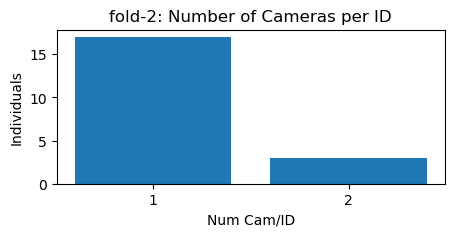

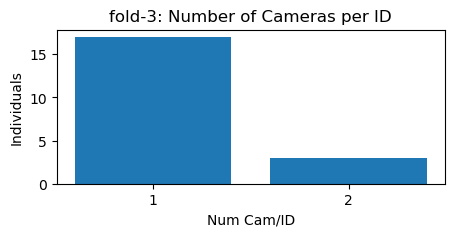

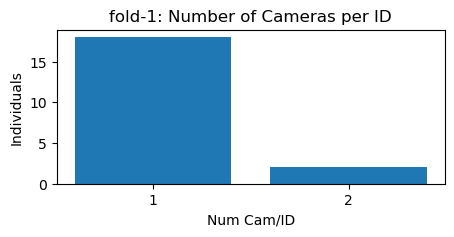

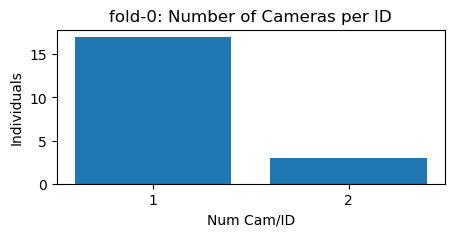

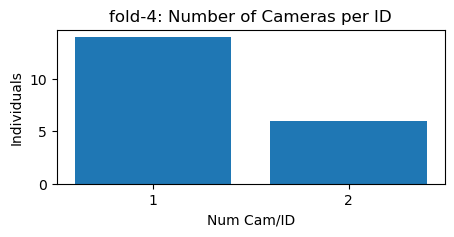

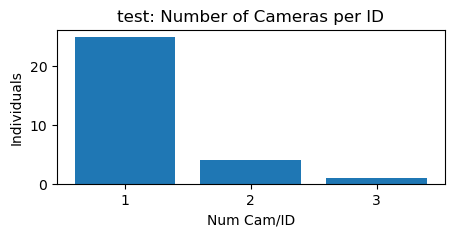

In [12]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM'])
    videos_per_id = unique_videos.groupby(['GROUP', 'ID']).size()
    videos_count_distribution = videos_per_id.value_counts().sort_index()
    plt.figure(figsize=(5, 2))
    plt.bar(videos_count_distribution.index, videos_count_distribution.values)
    plt.xlabel('Num Cam/ID')
    plt.ylabel('Individuals')
    plt.title(f'{d}: Number of Cameras per ID')
    plt.xticks(videos_count_distribution.index)
    plt.show()

## Images per Camera

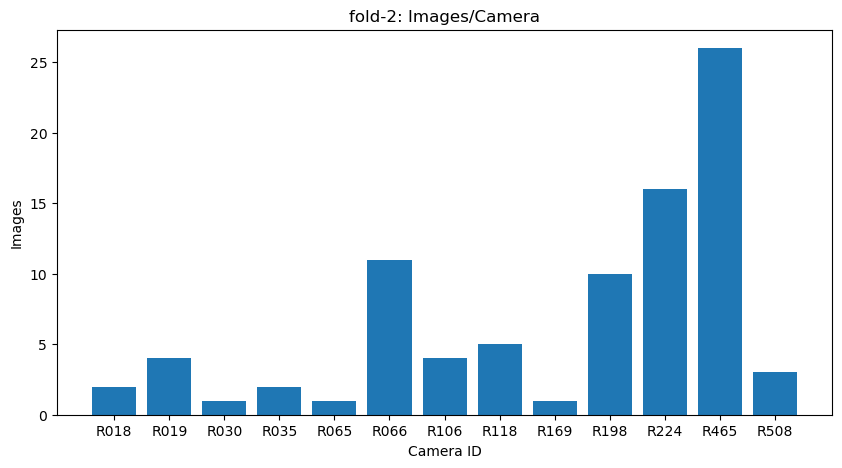

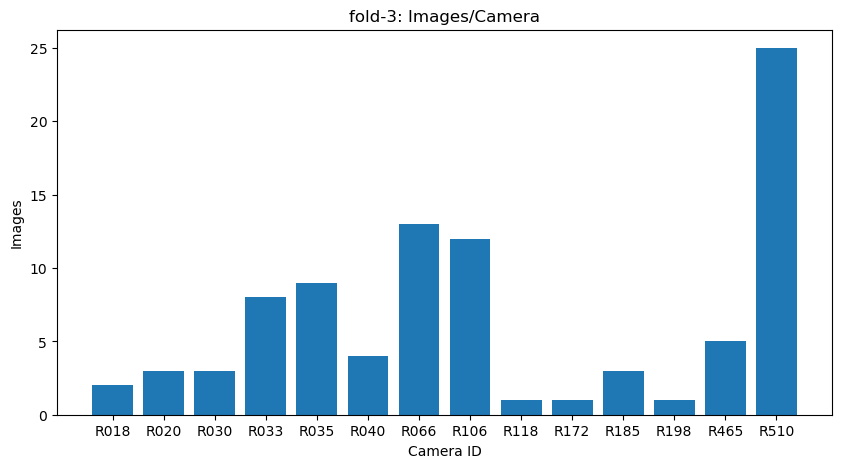

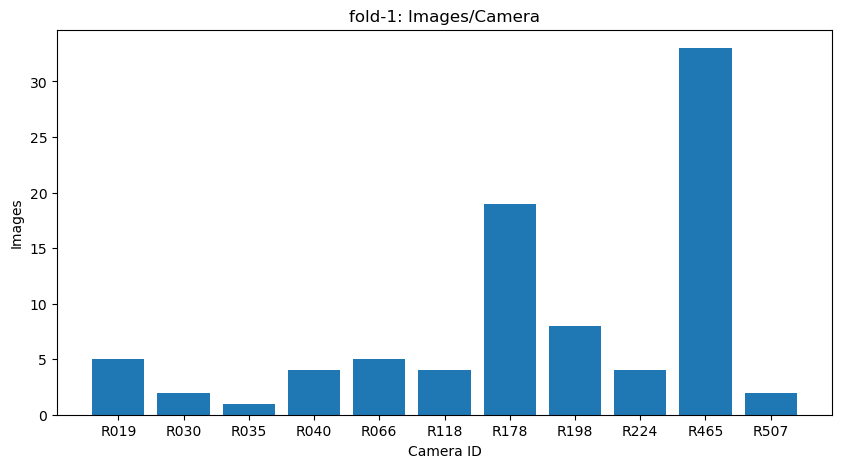

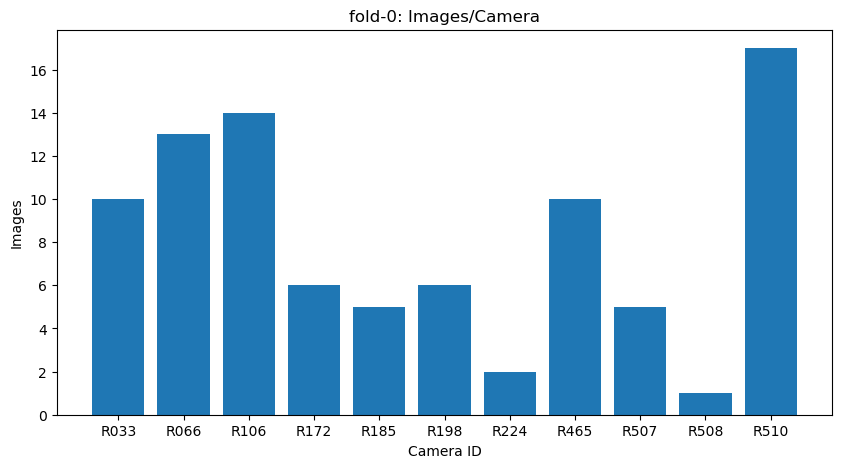

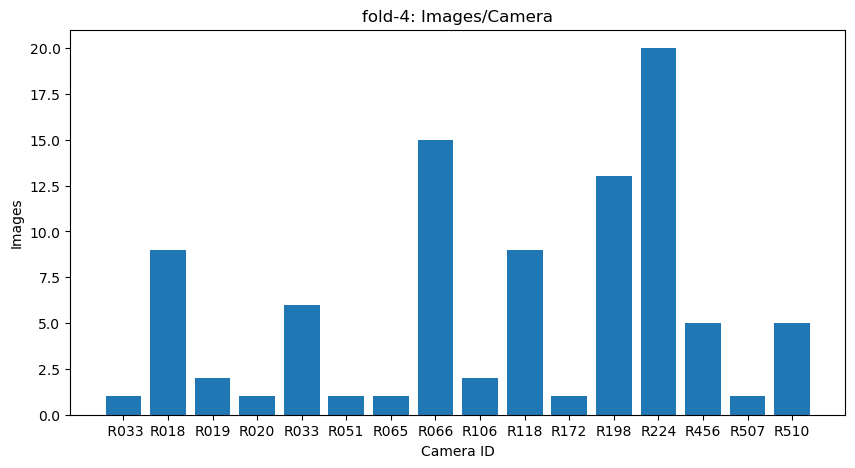

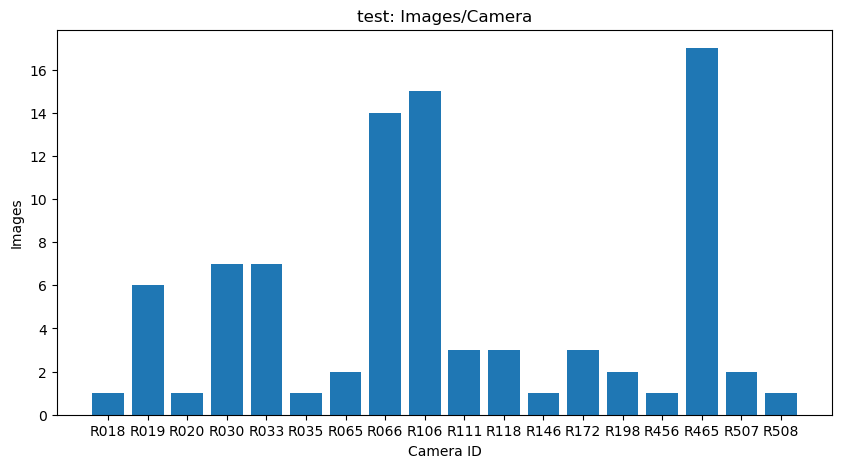

In [13]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
    images_per_camera = unique_videos.groupby('CAM').size()
    plt.figure(figsize=(10, 5))
    plt.bar(images_per_camera.index, images_per_camera.values)
    plt.xlabel('Camera ID')
    plt.ylabel('Images')
    plt.title(f'{d}: Images/Camera')
    plt.show()

## Individuals per Camera

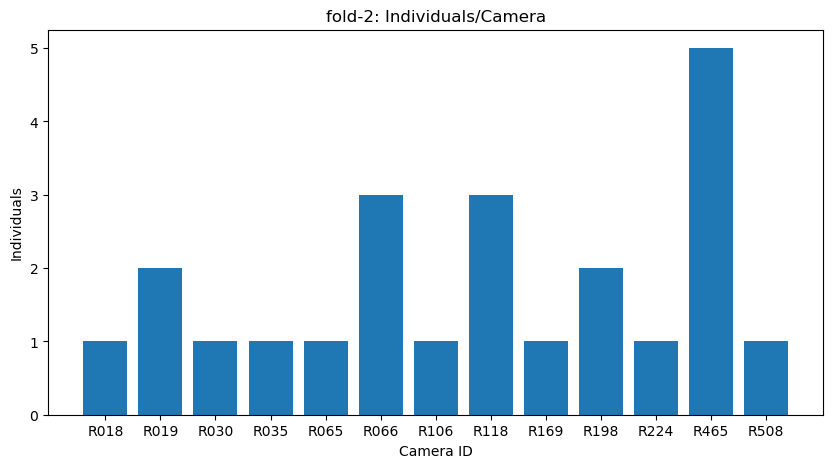

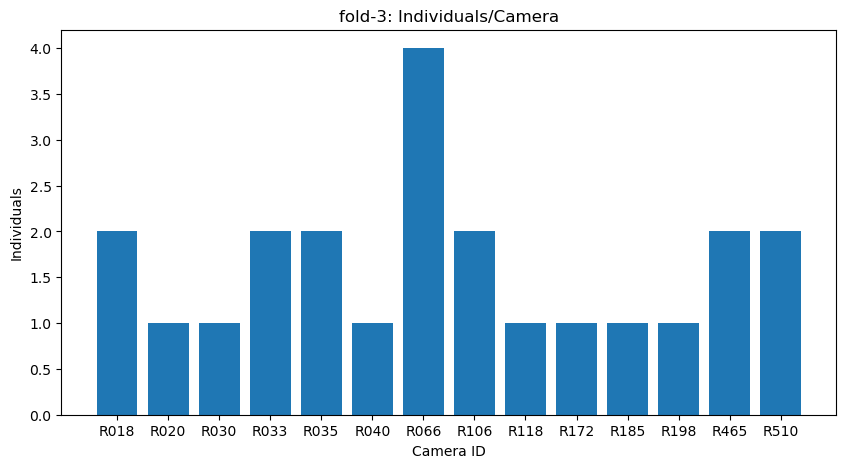

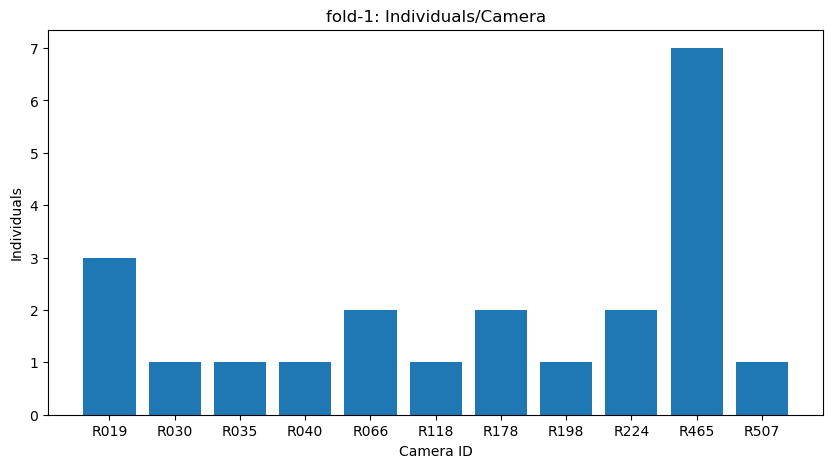

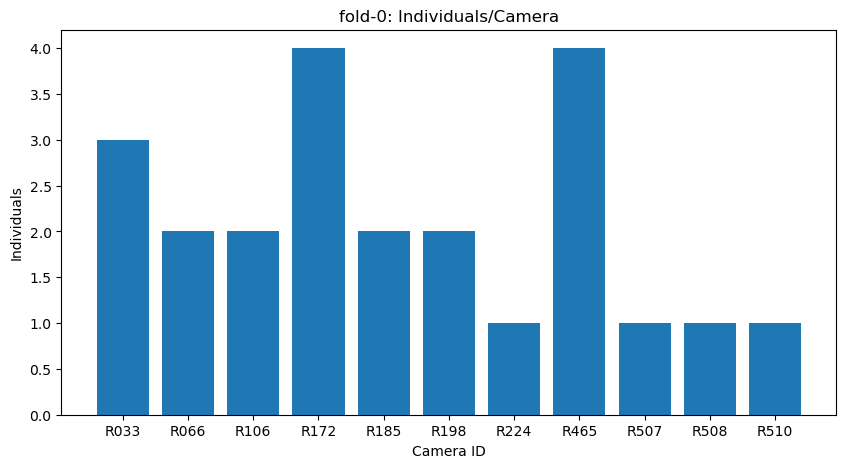

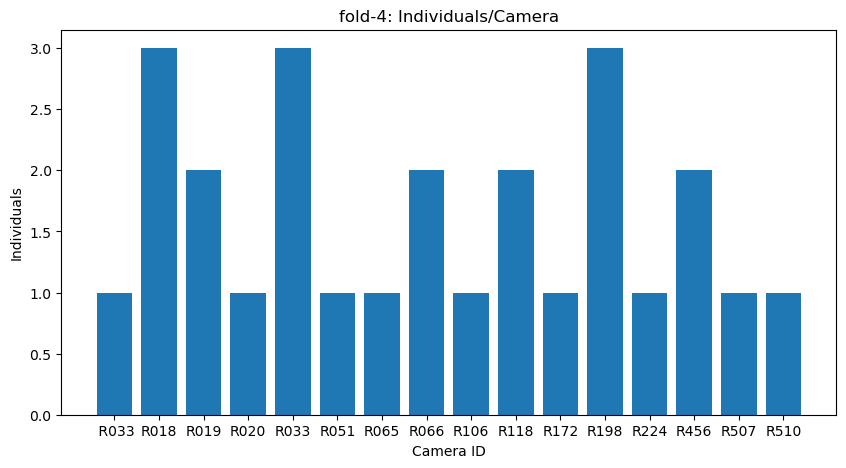

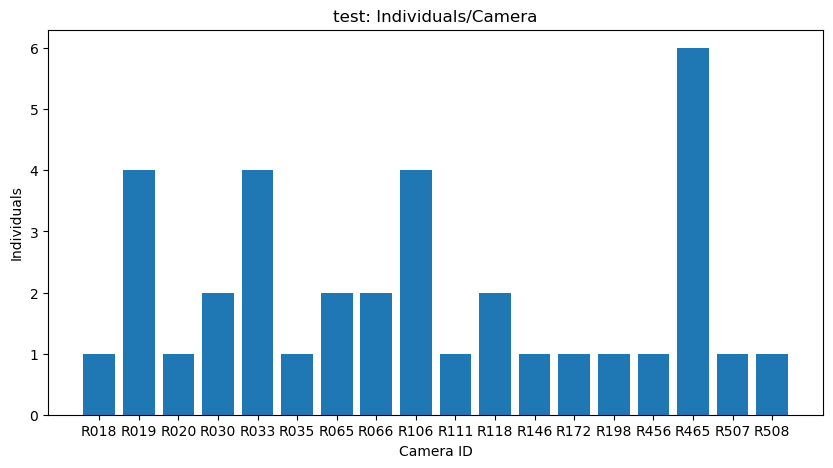

In [14]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
    individuals_per_camera = unique_videos.groupby(['CAM', 'GROUP', 'ID']).size().reset_index().groupby('CAM').size()
    plt.figure(figsize=(10, 5))
    plt.bar(individuals_per_camera.index, individuals_per_camera.values)
    plt.xlabel('Camera ID')
    plt.ylabel('Individuals')
    plt.title(f'{d}: Individuals/Camera')
    plt.show()

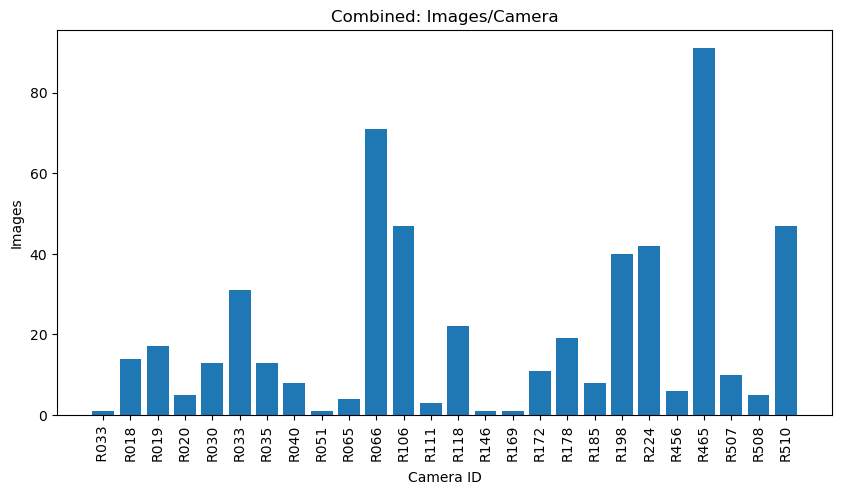

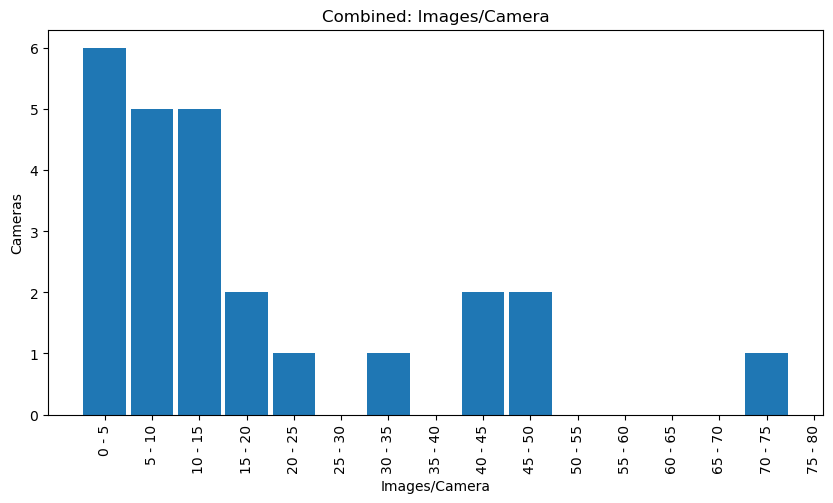

In [15]:
# combined
df_combined = pd.concat(df)
unique_videos = df_combined.drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
images_per_camera = unique_videos.groupby('CAM').size()
plt.figure(figsize=(10, 5))
plt.bar(images_per_camera.index, images_per_camera.values)
plt.xlabel('Camera ID')
plt.ylabel('Images')
plt.title('Combined: Images/Camera')
plt.xticks(rotation=90)
plt.show()

# make this plot a histogram with bins of 10 images per camera and show the number of cameras in each bin
# center the bins
plt.figure(figsize=(10, 5))
plt.hist(images_per_camera, bins=range(0, 80, 5), align='left', rwidth=0.9)
plt.xticks(ticks=range(0, 80, 5), labels=[f'{i} - {i+5}' for i in range(0, 80, 5)], rotation=90)
plt.xlabel('Images/Camera')
plt.ylabel('Cameras')
plt.title('Combined: Images/Camera')
plt.show()

## Individuals per Group

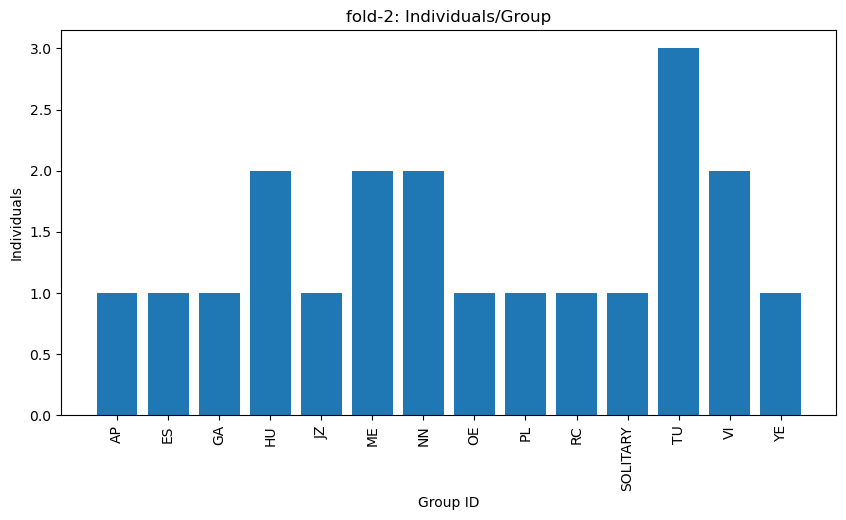

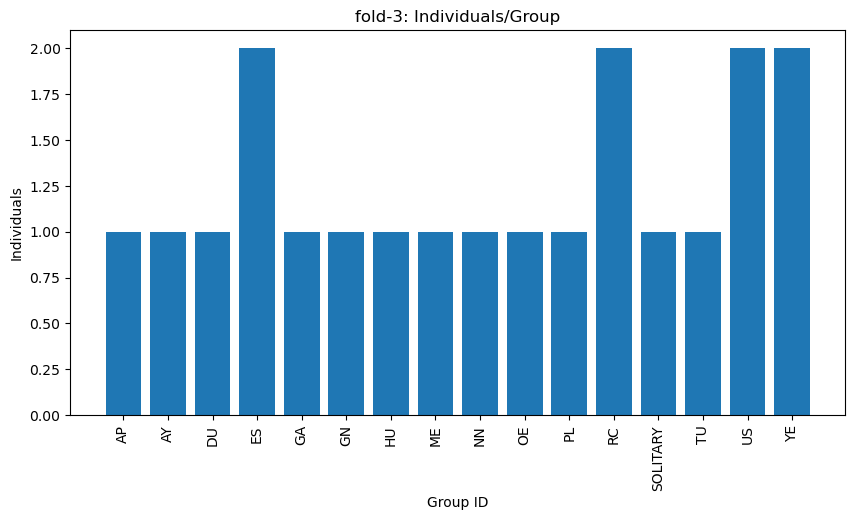

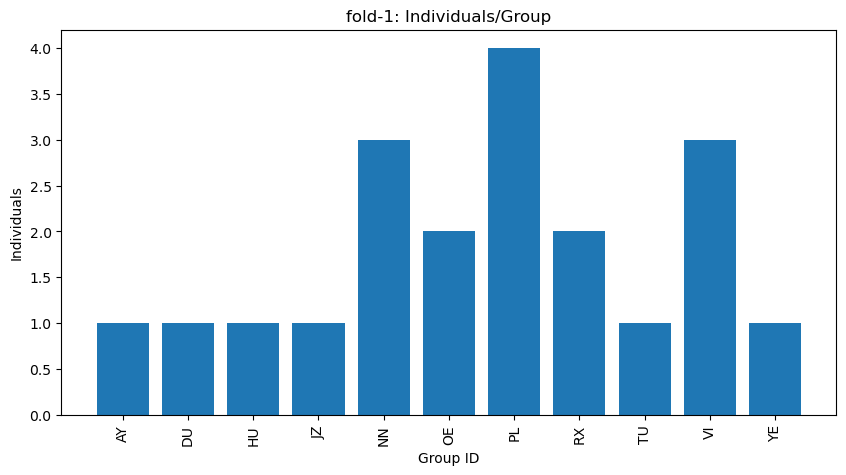

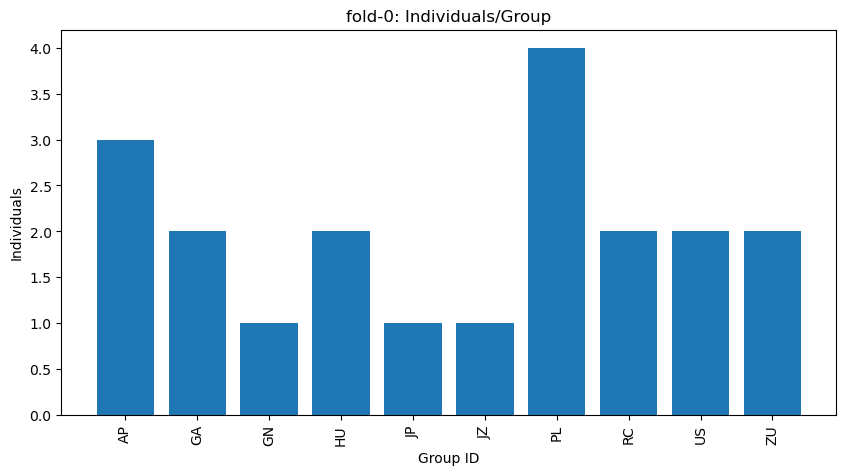

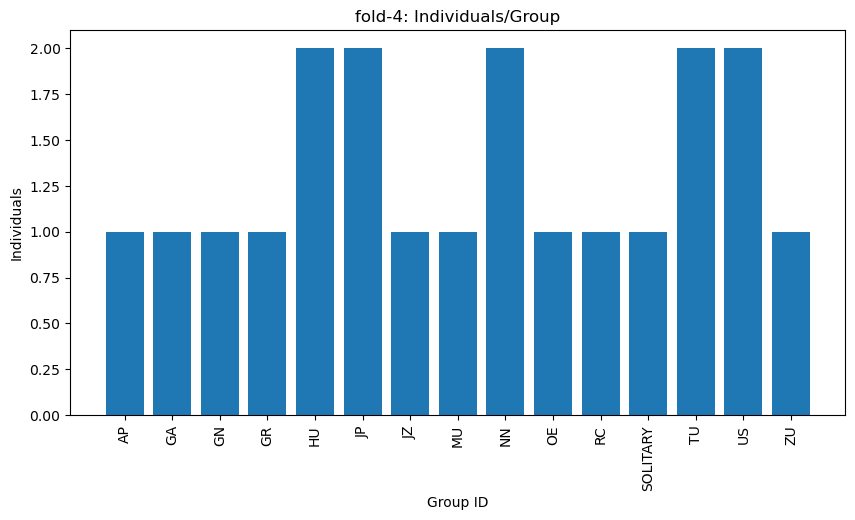

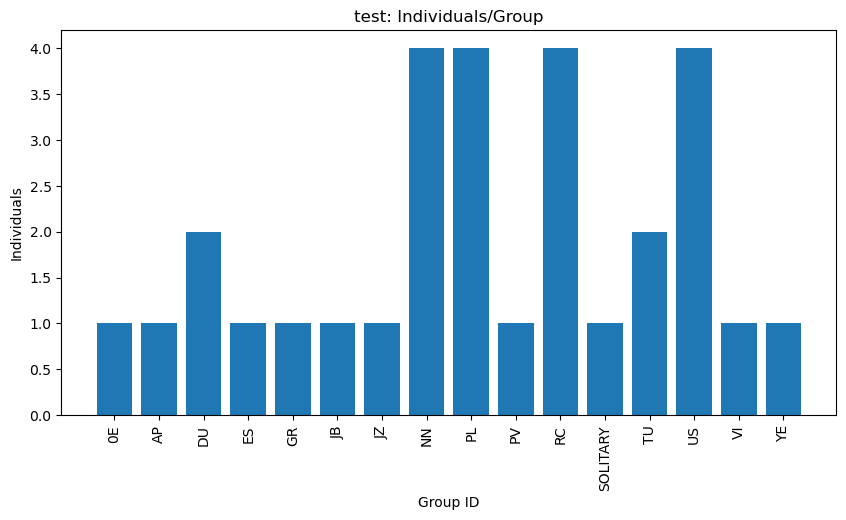

In [16]:
for i, d in enumerate(dirs):
    unique_videos = df[i].drop_duplicates(subset=['GROUP', 'ID', 'CAM', 'DATE', 'ID2'])
    unique_individuals_per_group = unique_videos.groupby(['GROUP', 'ID']).size().reset_index().groupby('GROUP').size()
    plt.figure(figsize=(10, 5))
    plt.bar(unique_individuals_per_group.index, unique_individuals_per_group.values)
    plt.xlabel('Group ID')
    plt.ylabel('Individuals')
    plt.title(f'{d}: Individuals/Group')
    plt.xticks(rotation=90)
    plt.show()

## Images per Category

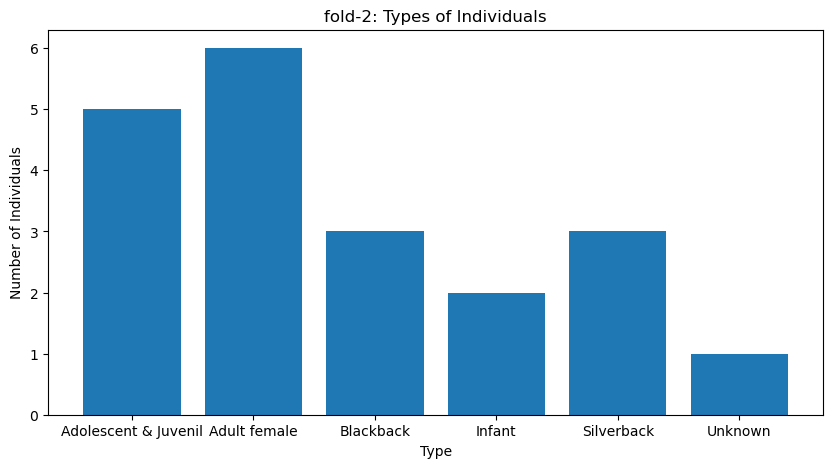

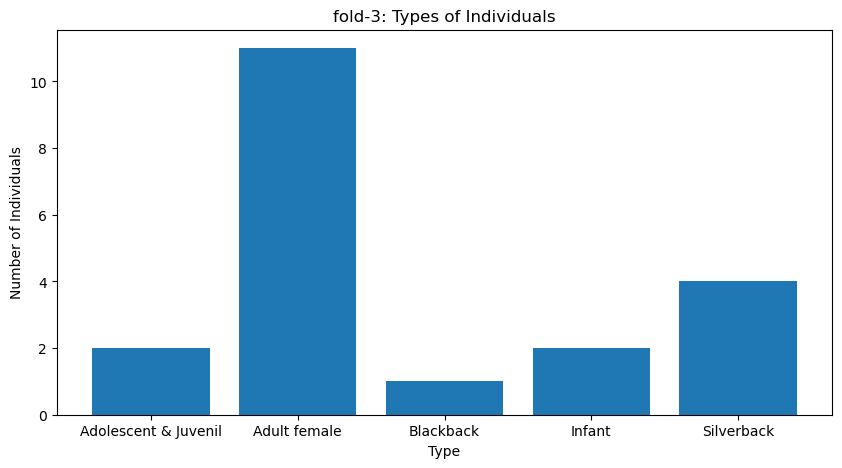

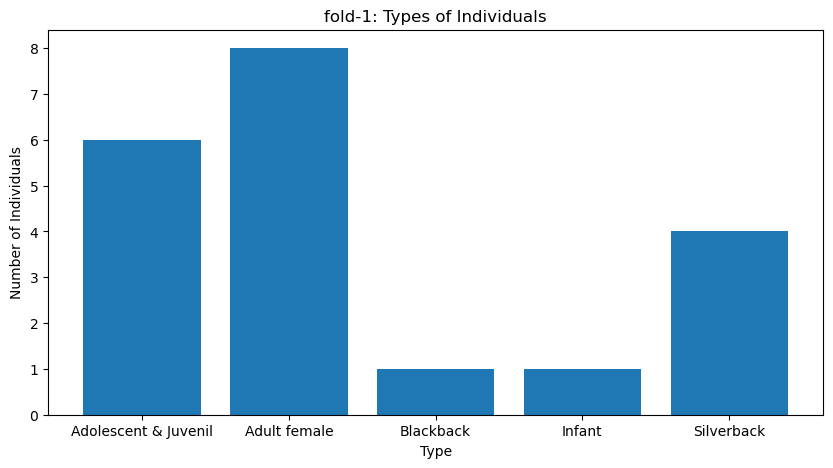

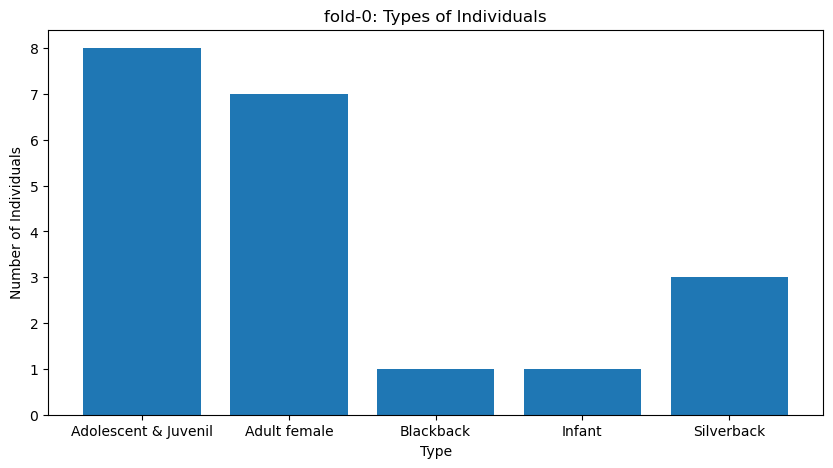

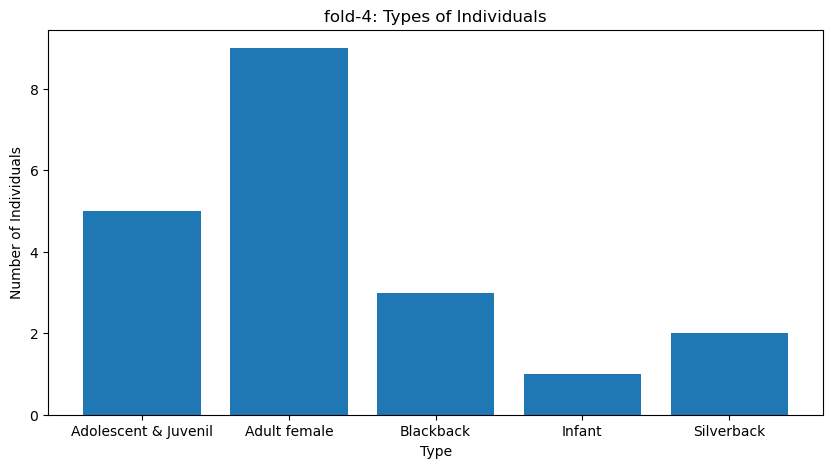

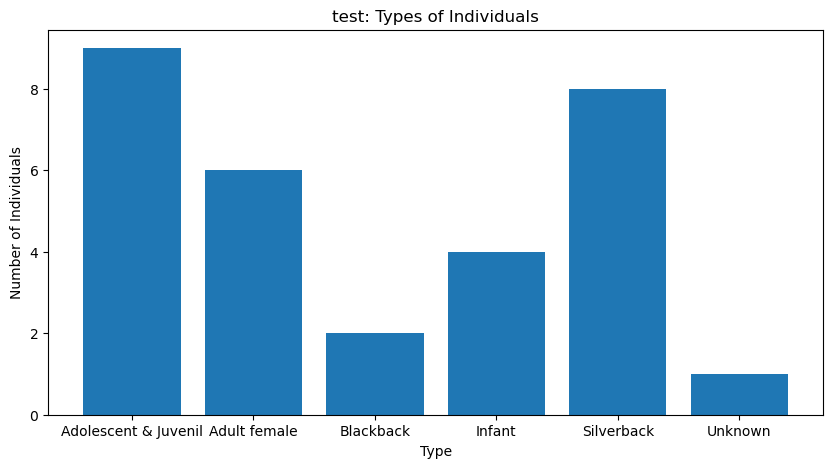

In [17]:
def categorize_id(id_):
    id_num = int(id_)
    if id_num == 0:
        return 'Silverback'
    elif 1 <= id_num <= 19:
        return 'Adult female'
    elif 20 <= id_num <= 39:
        return 'Blackback'
    elif 40 <= id_num <= 59:
        return 'Adolescent & Juvenil'
    elif 60 <= id_num <= 79:
        return 'Infant'
    else:
        return 'Unknown'

for i, d in enumerate(dirs):
    unique_individuals = df[i].drop_duplicates(subset=['GROUP', 'ID']).copy()
    # filter out non numeric IDs
    unique_individuals = unique_individuals[unique_individuals['ID'].str.isnumeric()]
    
    # Categorize each ID and add to the DataFrame using assign()
    unique_individuals = unique_individuals.assign(Type=unique_individuals['ID'].apply(categorize_id))
    
    # Calculate the number of each type
    type_distribution = unique_individuals['Type'].value_counts().sort_index()
    
    
    # Plot the distribution of types
    plt.figure(figsize=(10, 5))
    plt.bar(type_distribution.index, type_distribution.values)
    plt.xlabel('Type')
    plt.ylabel('Number of Individuals')
    plt.title(f'{d}: Types of Individuals')
    plt.show()

# Resolution of Images

In [18]:
# plot the resolution of all combined images 

from PIL import Image

img_sizes = []
for row in df_combined.itertuples():
    img = Image.open(os.path.join(dir_path, row[6]))
    img_sizes.append(img.size)
        
len(img_sizes)

1328

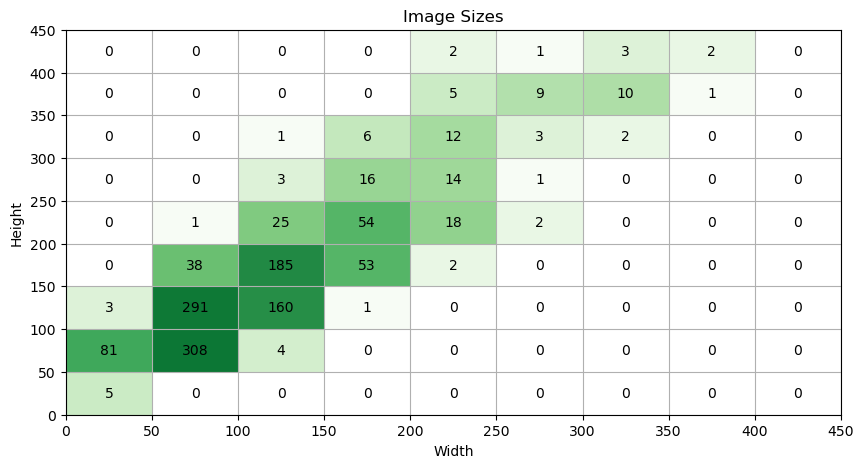

In [19]:
# make a matrix histogram of the image sizes (width x height)
from matplotlib.colors import Colormap, LogNorm
import numpy as np

plt.figure(figsize=(10, 5))
amounts_x, amounts_y = [x[0] for x in img_sizes], [x[1] for x in img_sizes]
norm = LogNorm(vmax=1000)
plt.hist2d(amounts_x, amounts_y, bins=range(0, 500, 50), cmap="Greens", norm=norm)
for i in range(0, 450, 50):
    for j in range(0, 450, 50):
        plt.text(i+25, j+25, f"{len([1 for x in img_sizes if i <= x[0] < i+50 and j <= x[1] < j+50])}", color='black', ha='center', va='center')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Sizes')
# plt.colorbar()
plt.grid()
plt.show()

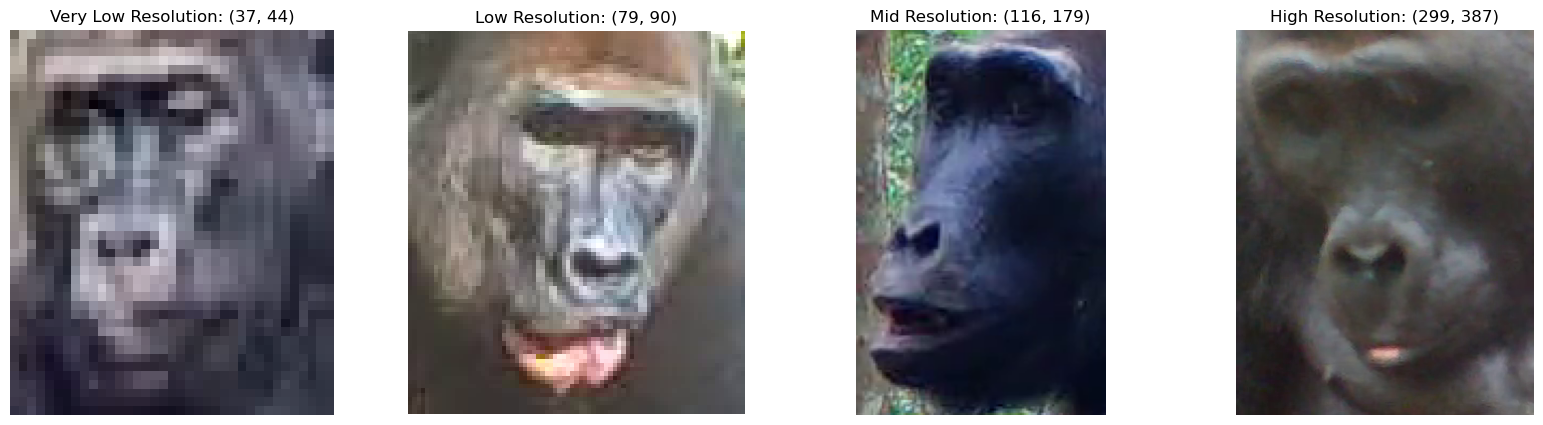

In [20]:
# plot one low mid and high resolution image
very_low_res = [x for x in img_sizes if x[0] < 50 and x[1] < 50][1]
low_res = [x for x in img_sizes if 50 <= x[0] < 100 and 50 <= x[1] < 100][0]
mid_res = [x for x in img_sizes if 100 <= x[0] < 200 and 100 <= x[1] < 200][0]
high_res = [x for x in img_sizes if x[0] > 200 and x[1] > 200][21]

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(Image.open(os.path.join(dir_path, df_combined.iloc[img_sizes.index(very_low_res)]['FILENAME'])))
plt.title(f"Very Low Resolution: {very_low_res}")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(Image.open(os.path.join(dir_path, df_combined.iloc[img_sizes.index(low_res)]['FILENAME'])))
plt.title(f"Low Resolution: {low_res}")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(Image.open(os.path.join(dir_path, df_combined.iloc[img_sizes.index(mid_res)]['FILENAME'])))
plt.title(f"Mid Resolution: {mid_res}")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(Image.open(os.path.join(dir_path, df_combined.iloc[img_sizes.index(high_res)]['FILENAME'])))
plt.title(f"High Resolution: {high_res}")
plt.axis('off')
plt.show() 